# [Log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)

## Probability density function

$ f(x) = \frac{1}{ \sigma \sqrt{2 \pi}} e^- \frac{1}{2} {(\frac{(x-\mu)}{\sigma})}^{2} $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os 
import pandas as pd
import math

## Observations: Protein length distribution in different species

### Retrieve the statistical description and tax_id of species

##### Statistical description data file

In [2]:
# system
system = list(os.uname())[0]
if system == 'Linux':
    base_dir = "/media/emuro/Wes/"
elif system == 'Darwin':
    base_dir = "/Volumes/Wes/"
    
# statistics on length distribution for different species     
stat_file = base_dir + "results/geneLength/outputInputFiles/" + "analysis/some_statistics/stat_description/" 
stat_file += "proteins/stat_description.protein.uniprot_reference_proteome.tsv"
print(stat_file)

# retrieve data
stat_df = pd.read_csv(stat_file, low_memory=False, sep="\t")
stat_df = stat_df[["superregnum", "species", "proteome_id", "tax_id", "uniprot_fasta_file", "count", "mean", "var"] + ["log10_mean", "log10_var"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(stat_df.head(2))
    print(stat_df.shape)

/media/emuro/Wes/results/geneLength/outputInputFiles/analysis/some_statistics/stat_description/proteins/stat_description.protein.uniprot_reference_proteome.tsv


,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
0,bacteria,Kurthia sp. 3B1D,UP000288623,1562256,/ftp.uniprot.org/pub/databases/uniprot/current...,3621.0,285.936205,36171.895653,2.372531,0.075378
1,viruses,Prochlorococcus phage P-GSP1,UP000204021,382262,/ftp.uniprot.org/pub/databases/uniprot/current...,49.0,238.285714,73651.083333,2.180820,0.155233


(19854, 10)


**Notes**: 
- Every species have a different tax_id
- Lots of "viruses" (9,915 that can be removed from here)

**Check**: A lot of species have more than one instance

## Python functions

In [3]:
# Function to plot the normal distribution
# blue: Observation
# red: Theoretical/Simulation
##########################################
def plot_log_norm (log10_len, mu, sigma, N, title, subtitle, xlabel, ylabel): # N is number of 
    print("N:", N, "mu:", mu, "\tsigma:", sigma)
    # my_normal_dist = np.random.normal(mu, sigma, N)  # no need to find a theoretical
    count, bins, *rest = plt.hist(log10_len, 60, density=True, alpha=0.4, edgecolor='black')
    
    # plt.hist(my_normal_dist, 30, density=True, alpha=0.25, color="r")
    # print(count); print(bins); print(*rest)
    plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
             np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
             linewidth=2, color='r', alpha=0.5)

    plt.vlines(x = mu, ymin = 0, ymax = 0.2, colors = 'white', label = 'mean') # mean
    plt.xlim([1,7]); plt.ylim([0,1.5])
    plt.suptitle(title); plt.title(subtitle + " (N=" + str(int(N)) +")")
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.show()

In [4]:
# species' stats for length distribution
def get_df_for_taxid(df, taxid):
     return df.loc[df["tax_id"]==taxid].copy()

In [5]:
def does_it_fits_normal(data_observed): 
    # Kurtosis and Skewness
    # =====================
    print('Kurtosis:', stats.kurtosis(data_observed))
    print('Skewness:', stats.skew(data_observed))
    # D'Agostino's K-squared test
    # ===========================
    k2, p_value = stats.normaltest(data_observed)
    print(f"D'Agostino's K-squared test(Estadístico={k2}, p-value={p_value})")

Deja de ser una log-normal (teóricamente)
- Kurtosis o Skewness: $\leq -1$ o $\geq 1$ 
- D'Agostino's K-squared test: p-value $ \leq 0.05 $, porque rechaza la hipótesis nula 

In [6]:
# The next function performs the whole analysis
def species_length_distribution__retrieve_plot_and_fit(stat_taxid_df, tax_id):
    species_df = get_df_for_taxid(stat_taxid_df, tax_id)
    species_df.drop_duplicates(subset=['tax_id'], inplace=True, keep='last')
    display(species_df)
    
    lengths_f = base_dir + "results/geneLength/" + species_df["uniprot_fasta_file"].item() 
    lengths_f = lengths_f.replace(".fasta.gz", ".length.tsv") # I get the 
    print(lengths_f)

    # retrieve data
    lens_df = pd.read_csv(lengths_f, sep="\t")
    lens_df = lens_df[["length"]]
    lens_df["log10_length"] = lens_df["length"].apply(np.log10)

    # visualize data
    pd.set_option('display.max_columns', None)
    if 0:
        display(lens_df.head(2))
        print(lens_df.shape)
    
    # plot the distributions: observed and theoretical
    title = species_df["species"].item().capitalize(); subtitle = "Observation";  xlabel = "Gene length"; ylabel = "PDF"
    plot_log_norm (lens_df["log10_length"], species_df["log10_mean"].item(), math.sqrt(species_df["log10_var"].item()), int(species_df["count"].item()), 
                   title, subtitle, xlabel, ylabel)  
    # fit to normal
    does_it_fits_normal(lens_df["log10_length"])

## Species:

### Homo sapiens
```{note}
tax_id = 9606
```

#### Retrieve statistical description

In [7]:
tax_id = 9696
human_df = get_df_for_taxid(stat_df, 9606)
display(human_df)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
18085,eukaryota,Homo sapiens (Human),UP000005640,9606,/ftp.uniprot.org/pub/databases/uniprot/current...,20614.0,552.845105,354913.157154,2.601146,0.125239


#### Retrieve genes

In [8]:
prots_f = base_dir + "results/geneLength/" + human_df["uniprot_fasta_file"].item() 
prots_f = prots_f.replace(".fasta.gz", ".length.tsv") # I get the 
print(prots_f)
# retrieve data
prots_df = pd.read_csv(prots_f, sep="\t")
prots_df = prots_df[["length"]]

# visualize data
pd.set_option('display.max_columns', None)
if 1:
    display(prots_df.head(2))
    print(prots_df.shape)

/media/emuro/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606.length.tsv


,length
0,2
1,4


(20614, 1)


#### Plot the log-normal

2.6011463573824893 0.3538905693139241 20614.0 Homo sapiens (human) Observation Protein length PDF
N: 20614 mu: 2.6011463573824893 	sigma: 0.3538905693139241


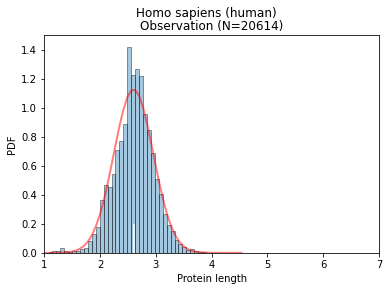

In [9]:
prots_df["log10_length"] = prots_df["length"].apply(np.log10)
title = human_df["species"].item().capitalize(); subtitle = "Observation";  xlabel = "Protein length"; ylabel = "PDF"
print(human_df["log10_mean"].item(), math.sqrt(human_df["log10_var"].item()), human_df["count"].item(), title, subtitle, xlabel, ylabel)  
plot_log_norm (prots_df["log10_length"], human_df["log10_mean"].item(), math.sqrt(human_df["log10_var"].item()), int(human_df["count"].item()), title, subtitle, xlabel, ylabel)  

#### Does the distribution fits the normal distribution?

In [10]:
does_it_fits_normal(prots_df["log10_length"]) 

Kurtosis: 1.163832716732534
Skewness: -0.26039124808735764
D'Agostino's K-squared test(Estadístico=717.1684257602484, p-value=1.8571844920422435e-156)


### Danio rerio

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
15373,eukaryota,Danio rerio (Zebrafish) (Brachydanio rerio),UP000000437,7955,/ftp.uniprot.org/pub/databases/uniprot/current...,25706.0,538.158329,315453.463435,2.599115,0.114029


/media/emuro/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000437/UP000000437_7955.length.tsv
N: 25706 mu: 2.599115440779346 	sigma: 0.3376817874330292


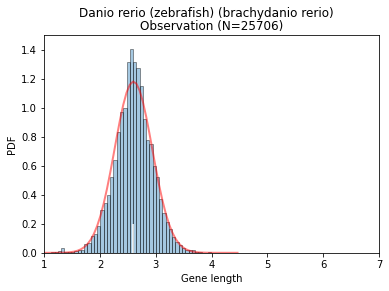

Kurtosis: 0.8752018347236281
Skewness: -0.138739152539118
D'Agostino's K-squared test(Estadístico=494.0354527107476, p-value=5.267014471006957e-108)


In [11]:
tax_id = 7955
species_length_distribution__retrieve_plot_and_fit(stat_df, 7955)

### Drosophila melanogaster

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
7340,eukaryota,Drosophila melanogaster (Fruit fly),UP000000803,7227,/ftp.uniprot.org/pub/databases/uniprot/current...,13821.0,535.649085,376540.881915,2.577192,0.131373


/media/emuro/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000000803/UP000000803_7227.length.tsv
N: 13821 mu: 2.5771919612400653 	sigma: 0.3624537280491678


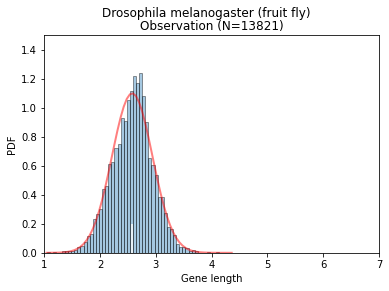

Kurtosis: 0.3248347849271651
Skewness: -0.08267683943107461
D'Agostino's K-squared test(Estadístico=61.497348374203234, p-value=4.4260923856861545e-14)


In [12]:
tax_id = 7227
species_length_distribution__retrieve_plot_and_fit(stat_df, 7227) # tax_id=7227

### Arabidopsis thaliana

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
9526,eukaryota,Arabidopsis thaliana (Mouse-ear cress),UP000006548,3702,/ftp.uniprot.org/pub/databases/uniprot/current...,27468.0,404.901267,90791.833554,2.499364,0.103077


/media/emuro/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000006548/UP000006548_3702.length.tsv
N: 27468 mu: 2.499363643151627 	sigma: 0.3210561738747564


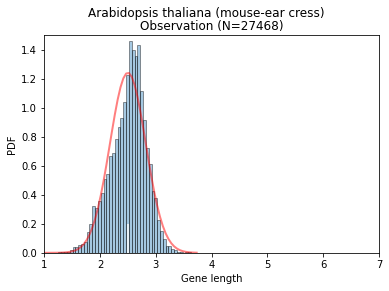

Kurtosis: 0.243976066210577
Skewness: -0.42554673286488875
D'Agostino's K-squared test(Estadístico=818.4263474448735, p-value=1.9097509301707898e-178)


In [13]:
tax_id = 3702
species_length_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### Saccharomyces cerevisae

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
1912,eukaryota,Saccharomyces cerevisiae (strain ATCC 204508 /...,UP000002311,559292,/ftp.uniprot.org/pub/databases/uniprot/current...,6050.0,485.36876,147051.60891,2.562528,0.118795


/media/emuro/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000002311/UP000002311_559292.length.tsv
N: 6050 mu: 2.562527686292433 	sigma: 0.3446669522663496


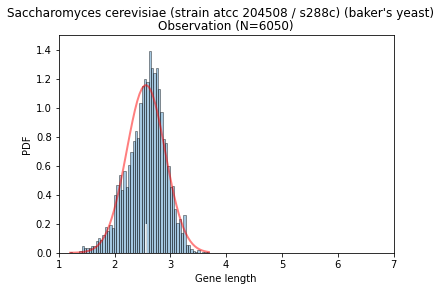

Kurtosis: 0.22362305398155113
Skewness: -0.4208344672192193
D'Agostino's K-squared test(Estadístico=175.7163528021762, p-value=6.977161873319256e-39)


In [14]:
tax_id = 559292 #ensembl: 4932 (no esta en uniprot)
species_length_distribution__retrieve_plot_and_fit(stat_df, tax_id)

### Escherichia coli

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var
13878,bacteria,Escherichia coli O157:H7,UP000000558,83334,/ftp.uniprot.org/pub/databases/uniprot/current...,5062.0,308.446859,57190.175698,2.38364,0.096586


/media/emuro/Wes/results/geneLength//ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000000558/UP000000558_83334.length.tsv
N: 5062 mu: 2.383639936200562 	sigma: 0.3107836062504229


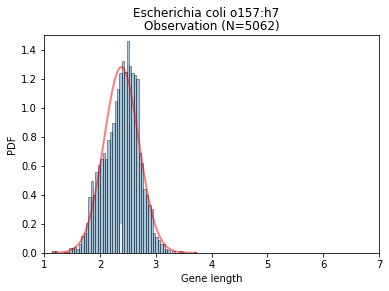

Kurtosis: -0.010812589593093058
Skewness: -0.2353062649782213
D'Agostino's K-squared test(Estadístico=45.62522286350297, p-value=1.2376810381172777e-10)


In [15]:
tax_id = 83334 # uniprot: 83333 (k12), 83334(0157:h7 disease), 1408285 (otra, this is not in ensembl) # ensembl: 562 (not in ref. uniprot)
species_length_distribution__retrieve_plot_and_fit(stat_df, tax_id)

##  Test species

In [16]:
tax_id = 10089  # E. coli: 83333 (k12), 83334(0157:h7 disease), 1408285 (otra, this is not in ensembl)
                # mus_caroli: 10089
                # Richelia_intracelularis (genes cortos): 1165094

species_length_distribution__retrieve_plot_and_fit(stat_df, tax_id)

,superregnum,species,proteome_id,tax_id,uniprot_fasta_file,count,mean,var,log10_mean,log10_var


ValueError: can only convert an array of size 1 to a Python scalar

## Select a set of species and show the distributions

In [ ]:
bee = stat_df.copy()
bee = bee[(bee["species"].str.contains("Apis")) |(bee["species"].str.contains("Bombus"))] # Some bees
bee = bee[(bee["superregnum"]=="eukaryota")]
display(bee)

for t in bee["tax_id"]:
    species_length_distribution__retrieve_plot_and_fit(stat_df, t)